### Step 2: Feature Engineering

Feature engineering combines the different data sources together to create a single data set of features (variables) that can be used to infer a machines's health condition over time. 

In this notebook we will load the data stored in Azure Blob containers created during the previous step, the **Data Ingestion** notebook (`Code/1_data_ingestion.ipynb`). The note book uses several feature engineering methods to create a data set for use in our predictive maintenance machine learning solution.

**Note:** This notebook will take about 20-30 minutes to execute all cells, depending on the compute configuration you have setup. 

In [1]:
## Setup our environment by importing required libraries
import time
import os
import glob

# Read csv file from URL directly
import pandas as pd

# For creating some preliminary EDA plots.
%matplotlib inline
import matplotlib.pyplot as plt
from ggplot import *

import pyspark.sql.functions as F
from pyspark.sql.functions import col, unix_timestamp, round
from pyspark.sql.functions import datediff
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

from pyspark.sql import SparkSession

# For Azure blob storage access
from azure.storage.blob import BlockBlobService
from azure.storage.blob import PublicAccess

# For logging model evaluation parameters back into the
# AML Workbench run history plots.
import logging
from azureml.logging import get_azureml_logger

amllog = logging.getLogger("azureml")
amllog.level = logging.INFO

# Turn on cell level logging.
%azureml history on
%azureml history show

# Time the notebook execution. 
# This will only make sense if you "Run all cells"
tic = time.time()

logger = get_azureml_logger() # logger writes to AMLWorkbench runtime view

spark = SparkSession.builder.getOrCreate()

# Telemetry
logger.log('amlrealworld.predictivemaintenance.feature_engineering','true')

History logging enabled
History logging is enabled


## Load data from Azure Blob storage container

We have previously downloaded and stored the following data in an Azure blob storage container:

  * Machines: Features differentiating each machine. For example age and model.
  * Error: The log of non-critical errors. These errors may still indicate an impending component failure.
  * Maint: Machine maintenance history detailing component replacement or regular maintenance activities withe the date of replacement.
  * Telemetry: The operating conditions of a machine e.g. data collected from sensors.
  * Failure history: The failure history of a machine or component within the machine.

We will load these files from blob and create our analysis data set here. We will then write this data set back into a new blob container to use in our model building and evaluation notebook later. 

Since the Azure Blob storage account name and account key are not passed between notebooks, you'll need to provide those here again.

In [2]:
# Enter your Azure blob storage details here 
ACCOUNT_NAME = "<your blob storage account name>"

# You can find the account key under the _Access Keys_ link in the 
# [Azure Portal](portal.azure.com) page for your Azure storage container.
ACCOUNT_KEY = "<your blob storage account key>"
#-------------------------------------------------------------------------------------------
# The data from the Data Aquisition note book is stored in the dataingestion container.
CONTAINER_NAME = "dataingestion"

# The data constructed in this notebook will be stored in the featureengineering container
STORAGE_CONTAINER_NAME = "featureengineering"

# Connect to your blob service     
az_blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)

# We will store each of these data sets in blob storage in an 
# Azure Storage Container on your Azure subscription.
# See https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md
# for details.

# These file names detail which blob each file is stored under. 
MACH_DATA = 'machines_files.parquet'
MAINT_DATA = 'maint_files.parquet'
ERROR_DATA = 'errors_files.parquet'
TELEMETRY_DATA = 'telemetry_files.parquet'
FAILURE_DATA = 'failure_files.parquet'

# These file names detail the local paths where we store the data results.
MACH_LOCAL_DIRECT = 'dataingestion_mach_result.parquet'
ERROR_LOCAL_DIRECT = 'dataingestion_err_result.parquet'
MAINT_LOCAL_DIRECT = 'dataingestion_maint_result.parquet'
TELEMETRY_LOCAL_DIRECT = 'dataingestion_tel_result.parquet'
FAILURES_LOCAL_DIRECT = 'dataingestion_fail_result.parquet'

# This is the final data file.
FEATURES_LOCAL_DIRECT = 'featureengineering_files.parquet'

### Machines data set

Load the machines data set from your Azure blob.

In [3]:
# create a local path  to store the data.
if not os.path.exists(MACH_LOCAL_DIRECT):
    os.makedirs(MACH_LOCAL_DIRECT)
    print('DONE creating a local directory!')

# Connect to blob storage container
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if MACH_DATA in blob.name:
        local_file = os.path.join(MACH_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

# Read in the data
machines = spark.read.parquet(MACH_LOCAL_DIRECT)

print(machines.count())
machines.limit(5).toPandas().head()

DONE creating a local directory!
1000


,machineID,model,age
0,1,model2,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model2,2


### Errors data set

Load the errors data set from your Azure blob.

In [4]:
if not os.path.exists(ERROR_LOCAL_DIRECT):
    os.makedirs(ERROR_LOCAL_DIRECT)
    print('DONE creating a local directory!')

# Connect to blob storage container
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if ERROR_DATA in blob.name:
        local_file = os.path.join(ERROR_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

# Read in the data
errors = spark.read.parquet(ERROR_LOCAL_DIRECT)

print(errors.count())
errors.limit(5).toPandas().head()

DONE creating a local directory!
11967


,datetime,machineID,errorID
0,2015-04-06 06:00:00,79,error5
1,2015-05-06 06:00:00,79,error1
2,2015-05-27 03:00:00,79,error2
3,2015-08-19 06:00:00,79,error2
4,2015-08-19 06:00:00,79,error3


### Maintenance data set

Load the maintenance data set from your Azure blob.

In [5]:
# create a local path  to store the data.
if not os.path.exists(MAINT_LOCAL_DIRECT):
    os.makedirs(MAINT_LOCAL_DIRECT)
    print('DONE creating a local directory!')

# Connect to blob storage container
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if MAINT_DATA in blob.name:
        local_file = os.path.join(MAINT_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

# Read in the data
maint = spark.read.parquet(MAINT_LOCAL_DIRECT)

print(maint.count())
maint.limit(5).toPandas().head()

DONE creating a local directory!
32592


,datetime,machineID,comp
0,2015-05-31 06:00:00,125,comp3
1,2015-05-31 06:00:00,125,comp4
2,2015-06-15 06:00:00,125,comp4
3,2015-06-15 06:00:00,125,comp3
4,2015-07-15 06:00:00,125,comp2


### Telemetry

Load the telemetry data set from your Azure blob.

In [6]:
# create a local path  to store the data.
if not os.path.exists(TELEMETRY_LOCAL_DIRECT):
    os.makedirs(TELEMETRY_LOCAL_DIRECT)
    print('DONE creating a local directory!')

# Connect to blob storage container
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if TELEMETRY_DATA in blob.name:
        local_file = os.path.join(TELEMETRY_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

# Read in the data
telemetry = spark.read.parquet(TELEMETRY_LOCAL_DIRECT)

print(telemetry.count())
telemetry.limit(5).toPandas().head()

DONE creating a local directory!
8761000


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-12-19 22:00:00,625,138.923911,332.555602,99.460533,43.493783
1,2015-12-19 23:00:00,625,173.839769,335.473306,103.150583,46.760175
2,2015-12-20 00:00:00,625,177.709243,456.502368,94.547367,42.063502
3,2015-12-20 01:00:00,625,176.464697,438.722509,106.360646,36.449788
4,2015-12-20 02:00:00,625,177.080815,407.972662,92.472901,33.644790


### Failures data set

Load the failures data set from your Azure blob.

In [7]:
# create a local path  to store the data.
if not os.path.exists(FAILURES_LOCAL_DIRECT):
    os.makedirs(FAILURES_LOCAL_DIRECT)
    print('DONE creating a local directory!')


# download the entire parquet result folder to local path for a new run 
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if FAILURE_DATA in blob.name:
        local_file = os.path.join(FAILURES_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

failures = spark.read.parquet(FAILURES_LOCAL_DIRECT).dropDuplicates(['machineID', 'datetime'])

print(failures.count())
failures.limit(5).toPandas().head()

DONE creating a local directory!
6368


,datetime,machineID,failure
0,2015-07-31 06:00:00,7,comp1
1,2015-02-17 06:00:00,179,comp4
2,2015-12-28 06:00:00,191,comp1
3,2015-06-13 06:00:00,221,comp2
4,2015-06-28 06:00:00,262,comp2


## Feature engineering 

Feature engineering combines the different data sources together to create a single data set of features (variables) that can be used to infer a machines's health condition over time. The ultimate goal is to generate a single record for each time unit for each asset combining its features and labels to be fed into the machine learning algorithm. In order to prepare that clean final data set, some pre-processing steps will be taken. The first step is to divide the duration of data collection into time units where each record belongs to a time unit for an asset.

The measurement unit for time can be in seconds, minutes, hours, days, months, cycles, miles or transactions depending on the efficiency of data preparation and the changes observed in the conditions of the asset from a time unit to the other or other factors specific to the domain. In other words, the time unit does not have to be the same as the frequency of data collection as in many cases data may not show any difference from one unit to the other. For example, if temperature values were being collected every 10 seconds, picking a time unit of 10 seconds for the whole analysis inflates the number of examples without providing any additional information. Better strategy would be to use average over an hour as an example.

### Rolling aggregates

For each record of an asset we pick a rolling window of size `W`, then compute rolling aggregate features using observations within the window `W` the date of each record. Some example rolling aggregates can be rolling counts, means, standard deviations, outliers based on standard deviations, CUSUM measures, minimum and maximum values for the window. Another interesting technique is to capture trend changes, spikes and level changes using algorithms that detect anomalies in data using anomaly detection algorithms.

### Lag features
As mentioned earlier, in predictive maintenance, historical data usually comes with timestamps indicating the time of collection for each piece of data. There are many ways of creating features from the data that comes with timestamped data. In this section, we discuss some of these methods used for predictive maintenance. However, we are not limited by these methods alone. Since feature engineering is considered to be one of the most creative areas of predictive modeling, there could be many other ways to create features. Here, we provide some general techniques.

## Telemetry features

Because the telemetry data set is the largest time series data we have, we start feature engineering here. 

A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the window. In the following, rolling mean and standard deviation of the telemetry data over the last 3 hour and 24 hour lag windows is calculated for every 3 hours.



In [8]:
# rolling mean and standard deviation
# Temporary storage for rolling means
tel_mean = telemetry

# Which features are we interested in telemetry data set
rolling_features = ['volt','rotate', 'pressure', 'vibration']
               
# We choose two windows for our rolling windows 3hrs, 24 hrs
lags = [3,24]

# 3 hours = 10800 seconds  
time_val = 3 * 60 * 60

# Choose the 3 hour timestamps to align the data
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

for lag_n in lags:
    wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-lag_n, 0)
    for col_name in rolling_features:
        tel_mean = tel_mean.withColumn(col_name+'_rollingmean_'+str(lag_n), F.avg(col(col_name)).over(wSpec))
        tel_mean = tel_mean.withColumn(col_name+'_rollingstd_'+str(lag_n), F.stddev(col(col_name)).over(wSpec))

telemetry_feat = (tel_mean.withColumn("dt_truncated", dt_truncated)
                  .drop('volt', 'rotate', 'pressure', 'vibration')
                  .fillna(0)
                  .groupBy("machineID","dt_truncated")
                  .agg(F.mean('volt_rollingmean_3').alias('volt_rollingmean_3'),
                       F.mean('rotate_rollingmean_3').alias('rotate_rollingmean_3'), 
                       F.mean('pressure_rollingmean_3').alias('pressure_rollingmean_3'), 
                       F.mean('vibration_rollingmean_3').alias('vibration_rollingmean_3'), 
                       F.mean('volt_rollingmean_24').alias('volt_rollingmean_24'),
                       F.mean('rotate_rollingmean_24').alias('rotate_rollingmean_24'), 
                       F.mean('pressure_rollingmean_24').alias('pressure_rollingmean_24'), 
                       F.mean('vibration_rollingmean_24').alias('vibration_rollingmean_24'),
                       F.stddev('volt_rollingstd_3').alias('volt_rollingstd_3'),
                       F.stddev('rotate_rollingstd_3').alias('rotate_rollingstd_3'), 
                       F.stddev('pressure_rollingstd_3').alias('pressure_rollingstd_3'), 
                       F.stddev('vibration_rollingstd_3').alias('vibration_rollingstd_3'), 
                       F.stddev('volt_rollingstd_24').alias('volt_rollingstd_24'),
                       F.stddev('rotate_rollingstd_24').alias('rotate_rollingstd_24'), 
                       F.stddev('pressure_rollingstd_24').alias('pressure_rollingstd_24'), 
                       F.stddev('vibration_rollingstd_24').alias('vibration_rollingstd_24')))

print(telemetry_feat.count())
telemetry_feat.where((col("machineID") == 1)).limit(10).toPandas().head(10)

2921000


,machineID,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingstd_3,rotate_rollingstd_3,pressure_rollingstd_3,vibration_rollingstd_3,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24
0,1,2015-01-09 06:00:00,161.758220,460.191228,96.335812,39.051541,168.100278,438.408323,100.435705,41.143014,2.542234,13.617558,1.636829,1.264601,0.390377,0.696726,0.390516,0.265077
1,1,2015-04-02 12:00:00,177.068429,433.378560,96.498988,38.821066,172.384126,447.099119,100.856740,39.575157,5.793824,12.301515,1.270456,0.217692,0.018506,0.784804,0.176249,0.034673
2,1,2015-04-11 18:00:00,171.014696,411.497993,97.440480,41.011138,172.095467,443.324774,98.037775,39.499885,6.437136,16.375696,3.145606,0.463779,0.219697,2.096753,0.296434,0.096999
3,1,2015-04-17 15:00:00,161.944471,429.707358,100.453624,43.356965,166.049779,442.574675,98.379748,41.186337,10.772187,1.933757,2.839066,3.337395,0.530808,0.569094,0.034361,0.037792
4,1,2015-04-18 21:00:00,178.593778,457.468729,101.436350,43.940496,172.648494,447.924559,99.065954,40.058577,4.205957,19.861217,4.228484,3.509604,0.304786,2.469812,0.436034,0.157498
5,1,2015-04-22 18:00:00,173.814460,481.608946,106.691878,38.773940,170.510248,458.411583,101.900838,41.187209,5.185854,23.642292,1.652761,0.906791,0.530828,3.221165,0.529525,0.025674
6,1,2015-05-12 00:00:00,177.166806,431.077395,98.427573,32.993633,171.314120,456.254551,101.924653,40.758712,11.157716,8.538429,1.468329,1.573847,0.624328,0.452415,0.265851,0.314688
7,1,2015-06-02 03:00:00,169.390774,421.496917,111.307572,41.276803,165.348173,447.698849,100.007553,39.866762,0.479267,11.691539,1.553642,0.801571,0.222697,1.168570,0.287293,0.025985
8,1,2015-07-26 12:00:00,165.344056,442.703231,87.036960,40.620244,168.613437,445.626234,96.981386,39.743980,5.748553,11.023769,4.968860,2.466889,0.785477,0.683333,0.425018,0.094826
9,1,2015-08-04 00:00:00,165.434594,492.411368,102.873017,39.090342,171.040596,474.751091,102.689331,42.860270,3.807173,3.990032,3.853427,0.570134,0.162140,1.228408,0.353189,0.056700


## Errors features

Like telemetry data, errors come with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type in a lagging window. We begin by reformatting the error data to have one entry per machine per time at which at least one error occurred.

In [9]:
# create a column for each errorID 
error_ind = (errors.groupBy("machineID","datetime","errorID").pivot('errorID')
             .agg(F.count('machineID').alias('dummy')).drop('errorID').fillna(0)
             .groupBy("machineID","datetime")
             .agg(F.sum('error1').alias('error1sum'), 
                  F.sum('error2').alias('error2sum'), 
                  F.sum('error3').alias('error3sum'), 
                  F.sum('error4').alias('error4sum'), 
                  F.sum('error5').alias('error5sum')))

# join the telemetry data with errors
error_count = (telemetry.join(error_ind, 
                              ((telemetry['machineID'] == error_ind['machineID']) 
                               & (telemetry['datetime'] == error_ind['datetime'])), "left")
               .drop('volt', 'rotate', 'pressure', 'vibration')
               .drop(error_ind.machineID).drop(error_ind.datetime)
               .fillna(0))

error_features = ['error1sum','error2sum', 'error3sum', 'error4sum', 'error5sum']

wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-24, 0)
for col_name in error_features:
    error_count = error_count.withColumn(col_name+'_rollingmean_'+str(lag_n), 
                                         F.avg(col(col_name)).over(wSpec))

error_feat = (error_count.withColumn("dt_truncated", dt_truncated)
              .drop('error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum').fillna(0)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('error1sum_rollingmean_24').alias('error1sum_rollingmean_24'), 
                   F.mean('error2sum_rollingmean_24').alias('error2sum_rollingmean_24'), 
                   F.mean('error3sum_rollingmean_24').alias('error3sum_rollingmean_24'), 
                   F.mean('error4sum_rollingmean_24').alias('error4sum_rollingmean_24'), 
                   F.mean('error5sum_rollingmean_24').alias('error5sum_rollingmean_24')))

print(error_feat.count())
error_feat.limit(10).toPandas().head(10)

2921000


,machineID,dt_truncated,error1sum_rollingmean_24,error2sum_rollingmean_24,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24
0,29,2015-01-26 03:00:00,0.0,0.0,0.0,0.0,0.0
1,29,2015-01-29 21:00:00,0.0,0.0,0.0,0.0,0.0
2,474,2015-01-05 03:00:00,0.0,0.0,0.0,0.0,0.0
3,474,2015-01-17 09:00:00,0.0,0.0,0.0,0.0,0.0
4,26,2015-03-01 21:00:00,0.0,0.0,0.0,0.0,0.0
5,26,2015-04-15 18:00:00,0.0,0.0,0.0,0.0,0.0
6,26,2015-04-27 12:00:00,0.0,0.0,0.0,0.0,0.0
7,26,2015-05-31 15:00:00,0.0,0.0,0.0,0.0,0.0
8,26,2015-06-16 06:00:00,0.0,0.0,0.0,0.0,0.0
9,26,2015-06-27 18:00:00,0.0,0.0,0.0,0.0,0.0


## Days since last replacement from maintenance 

A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected.

As a side note, creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a crucial role in understanding the predictors of a problem. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data.

We start by counting the component replacements.

In [10]:
# create a column for each component replacement
maint_replace = (maint.groupBy("machineID","datetime","comp").pivot('comp')
                 .agg(F.count('machineID').alias('dummy')).fillna(0)
                 .groupBy("machineID","datetime")
                 .agg(F.sum('comp1').alias('comp1sum'), 
                      F.sum('comp2').alias('comp2sum'), 
                      F.sum('comp3').alias('comp3sum'),
                      F.sum('comp4').alias('comp4sum')))

maint_replace = maint_replace.withColumnRenamed('datetime','datetime_maint')

print(maint_replace.count())
maint_replace.limit(10).toPandas().head(10)

25121


,machineID,datetime_maint,comp1sum,comp2sum,comp3sum,comp4sum
0,191,2015-12-28 06:00:00,1,0,0,0
1,567,2015-09-17 06:00:00,0,0,0,1
2,301,2015-04-04 06:00:00,1,1,0,0
3,852,2015-06-14 06:00:00,0,0,1,0
4,942,2015-09-23 06:00:00,0,0,1,1
5,66,2015-09-30 06:00:00,0,0,1,0
6,370,2015-07-22 06:00:00,0,1,0,1
7,512,2015-05-03 06:00:00,0,0,1,0
8,427,2015-06-15 06:00:00,0,0,1,1
9,490,2015-10-26 06:00:00,1,1,0,0


Features are created by tracking the number of days between each component replacement. We'll repeat these calculations for each of the four components, and join them together into a maintenance feature table.

First `comp1`:

In [11]:
# We want to align the component information on telemetry features timestamps.
telemetry_times = (telemetry_feat.select(telemetry_feat.machineID, telemetry_feat.dt_truncated)
                   .withColumnRenamed('dt_truncated','datetime_tel'))

# Grab component 1 records
maint_comp1 = (maint_replace.where(col("comp1sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp2sum', 'comp3sum', 'comp4sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp1 = (telemetry_times.join(maint_comp1, 
                                        ((telemetry_times ['machineID']== maint_comp1['machineID']) 
                                         & (telemetry_times ['datetime_tel'] > maint_comp1['datetime_maint']) 
                                         & ( maint_comp1['comp1sum'] == '1')))
                   .drop(maint_comp1.machineID))

# Calculate the number of days between replacements
comp1 = (maint_tel_comp1.withColumn("sincelastcomp1", 
                                    datediff(maint_tel_comp1.datetime_tel, maint_tel_comp1.datetime_maint))
         .drop(maint_tel_comp1.datetime_maint).drop(maint_tel_comp1.comp1sum))

print(comp1.count())
comp1.filter(comp1.machineID == '625').orderBy(comp1.datetime_tel).limit(20).toPandas().head(20)

12986520


,machineID,datetime_tel,sincelastcomp1
0,625,2015-01-01 06:00:00,94
1,625,2015-01-01 09:00:00,94
2,625,2015-01-01 12:00:00,94
3,625,2015-01-01 15:00:00,94
4,625,2015-01-01 18:00:00,94
5,625,2015-01-01 21:00:00,94
6,625,2015-01-02 00:00:00,95
7,625,2015-01-02 03:00:00,95
8,625,2015-01-02 06:00:00,95
9,625,2015-01-02 09:00:00,95


Then `comp2`:

In [12]:
# Grab component 2 records
maint_comp2 = (maint_replace.where(col("comp2sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp3sum', 'comp4sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp2 = (telemetry_times.join(maint_comp2, 
                                        ((telemetry_times ['machineID']== maint_comp2['machineID']) 
                                         & (telemetry_times ['datetime_tel'] > maint_comp2['datetime_maint']) 
                                         & ( maint_comp2['comp2sum'] == '1')))
                   .drop(maint_comp2.machineID))

# Calculate the number of days between replacements
comp2 = (maint_tel_comp2.withColumn("sincelastcomp2", 
                                    datediff(maint_tel_comp2.datetime_tel, maint_tel_comp2.datetime_maint))
         .drop(maint_tel_comp2.datetime_maint).drop(maint_tel_comp2.comp2sum))

print(comp2.count())
comp2.filter(comp2.machineID == '625').orderBy(comp2.datetime_tel).limit(5).toPandas().head(5)

13083392


,machineID,datetime_tel,sincelastcomp2
0,625,2015-01-01 06:00:00,19
1,625,2015-01-01 09:00:00,19
2,625,2015-01-01 12:00:00,19
3,625,2015-01-01 15:00:00,19
4,625,2015-01-01 18:00:00,19


Then `comp3`:

In [13]:
# Grab component 3 records
maint_comp3 = (maint_replace.where(col("comp3sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp2sum', 'comp4sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp3 = (telemetry_times.join(maint_comp3, ((telemetry_times ['machineID']==maint_comp3['machineID']) 
                                                      & (telemetry_times ['datetime_tel'] > maint_comp3['datetime_maint']) 
                                                      & ( maint_comp3['comp3sum'] == '1')))
                   .drop(maint_comp3.machineID))

# Calculate the number of days between replacements
comp3 = (maint_tel_comp3.withColumn("sincelastcomp3", 
                                    datediff(maint_tel_comp3.datetime_tel, maint_tel_comp3.datetime_maint))
         .drop(maint_tel_comp3.datetime_maint).drop(maint_tel_comp3.comp3sum))


print(comp3.count())
comp3.filter(comp3.machineID == '625').orderBy(comp3.datetime_tel).limit(5).toPandas().head(5)

13349528


,machineID,datetime_tel,sincelastcomp3
0,625,2015-01-01 06:00:00,19
1,625,2015-01-01 09:00:00,19
2,625,2015-01-01 12:00:00,19
3,625,2015-01-01 15:00:00,19
4,625,2015-01-01 18:00:00,19


Then `comp4`:

In [14]:
# Grab component 4 records
maint_comp4 = (maint_replace.where(col("comp4sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp2sum', 'comp3sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp4 = telemetry_times.join(maint_comp4, ((telemetry_times['machineID']==maint_comp4['machineID']) 
                                                     & (telemetry_times['datetime_tel'] > maint_comp4['datetime_maint']) 
                                                     & (maint_comp4['comp4sum'] == '1'))).drop(maint_comp4.machineID)

# Calculate the number of days between replacements
comp4 = (maint_tel_comp4.withColumn("sincelastcomp4", 
                                    datediff(maint_tel_comp4.datetime_tel, maint_tel_comp4.datetime_maint))
         .drop(maint_tel_comp4.datetime_maint).drop(maint_tel_comp4.comp4sum))

print(comp4.count())
comp4.filter(comp4.machineID == '625').orderBy(comp4.datetime_tel).limit(5).toPandas().head(5)

13063176


,machineID,datetime_tel,sincelastcomp4
0,625,2015-01-01 06:00:00,139
1,625,2015-01-01 09:00:00,139
2,625,2015-01-01 12:00:00,139
3,625,2015-01-01 15:00:00,139
4,625,2015-01-01 18:00:00,139


Now, we join the four component replacement tables together. once joined we take the average across 3 hour observation windows.

In [15]:
# Join component 3 and 4
comp3_4 = (comp3.join(comp4, ((comp3['machineID'] == comp4['machineID']) 
                              & (comp3['datetime_tel'] == comp4['datetime_tel'])), "left")
           .drop(comp4.machineID).drop(comp4.datetime_tel))

# Join component 2 to 3 and 4
comp2_3_4 = (comp2.join(comp3_4, ((comp2['machineID'] == comp3_4['machineID']) 
                                  & (comp2['datetime_tel'] == comp3_4['datetime_tel'])), "left")
             .drop(comp3_4.machineID).drop(comp3_4.datetime_tel))

# Join component 1 to 2, 3 and 4
comps_feat = (comp1.join(comp2_3_4, ((comp1['machineID'] == comp2_3_4['machineID']) 
                                      & (comp1['datetime_tel'] == comp2_3_4['datetime_tel'])), "left")
               .drop(comp2_3_4.machineID).drop(comp2_3_4.datetime_tel)
               .groupBy("machineID", "datetime_tel")
               .agg(F.max('sincelastcomp1').alias('sincelastcomp1'), 
                    F.max('sincelastcomp2').alias('sincelastcomp2'), 
                    F.max('sincelastcomp3').alias('sincelastcomp3'), 
                    F.max('sincelastcomp4').alias('sincelastcomp4'))
               .fillna(0))

# Choose the 3 hour timestamps to align the data
dt_truncated = ((round(unix_timestamp(col("datetime_tel")) / time_val) * time_val).cast("timestamp"))

# Collect data
maint_feat = (comps_feat.withColumn("dt_truncated", dt_truncated)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('sincelastcomp1').alias('comp1sum'), 
                   F.mean('sincelastcomp2').alias('comp2sum'), 
                   F.mean('sincelastcomp3').alias('comp3sum'), 
                   F.mean('sincelastcomp4').alias('comp4sum')))

print(maint_feat.count())
maint_feat.limit(10).toPandas().head(10)

2921000


,machineID,dt_truncated,comp1sum,comp2sum,comp3sum,comp4sum
0,1,2015-01-09 06:00:00,117.0,117.0,57.0,192.0
1,1,2015-04-02 12:00:00,200.0,200.0,140.0,275.0
2,1,2015-04-11 18:00:00,209.0,209.0,149.0,284.0
3,1,2015-04-17 15:00:00,215.0,215.0,155.0,290.0
4,1,2015-04-18 21:00:00,216.0,216.0,156.0,291.0
5,1,2015-04-22 18:00:00,220.0,220.0,160.0,295.0
6,1,2015-05-12 00:00:00,240.0,240.0,180.0,315.0
7,1,2015-06-02 03:00:00,261.0,261.0,201.0,336.0
8,1,2015-07-26 12:00:00,315.0,315.0,255.0,390.0
9,1,2015-08-04 00:00:00,324.0,324.0,264.0,399.0


## Machine features

The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

We do need to create a set of dummy features, boolean variables to indicate the model name of the machine. This is a _one-hot encoding_ step. 

In [16]:
# one hot encoding of the variable model, basically creates a set of dummy boolean variables
catVarNames = ['model']  
sIndexers = [StringIndexer(inputCol=x, outputCol=x + '_indexed') for x in catVarNames]
machines_cat = Pipeline(stages=sIndexers).fit(machines).transform(machines)

# one-hot encode
ohEncoders = [OneHotEncoder(inputCol=x + '_indexed', outputCol=x + '_encoded')
              for x in catVarNames]

ohPipelineModel = Pipeline(stages=ohEncoders).fit(machines_cat)
machines_cat = ohPipelineModel.transform(machines_cat)

drop_list = [col_n for col_n in machines_cat.columns if 'indexed' in col_n]

machines_feat = machines_cat.select([column for column in machines_cat.columns if column not in drop_list])

print(machines_feat.count())
machines_feat.limit(10).toPandas().head(10)

1000


,machineID,model,age,model_encoded
0,1,model2,18,"(0.0, 0.0, 1.0)"
1,2,model4,7,"(0.0, 1.0, 0.0)"
2,3,model3,8,"(1.0, 0.0, 0.0)"
3,4,model3,7,"(1.0, 0.0, 0.0)"
4,5,model2,2,"(0.0, 0.0, 1.0)"
5,6,model3,7,"(1.0, 0.0, 0.0)"
6,7,model4,20,"(0.0, 1.0, 0.0)"
7,8,model3,16,"(1.0, 0.0, 0.0)"
8,9,model1,7,"(0.0, 0.0, 0.0)"
9,10,model1,10,"(0.0, 0.0, 0.0)"


## Merging feature data

Next, we merge the telemetry, maintenance, machine and error feature data sets into a large feature data set.

In [17]:
# join error features with component maintenance features
error_maint = (error_feat.join(maint_feat, 
                               ((error_feat['machineID'] == maint_feat['machineID']) 
                                & (error_feat['dt_truncated'] == maint_feat['dt_truncated'])), "left")
               .drop(maint_feat.machineID).drop(maint_feat.dt_truncated))

# now join that with machines features
error_maint_feat = (error_maint.join(machines_feat, 
                                     ((error_maint['machineID'] == machines_feat['machineID'])), "left")
                    .drop(machines_feat.machineID))

# Clean up some unecessary columns
error_maint_feat = error_maint_feat.select([c for c in error_maint_feat.columns if c not in 
                                            {'error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum'}])

# join telemetry_all with error/maint/machine features to create final feature matrix
final_feat = (telemetry_feat.join(error_maint_feat, 
                                  ((telemetry_feat['machineID'] == error_maint_feat['machineID']) 
                                   & (telemetry_feat['dt_truncated'] == error_maint_feat['dt_truncated'])), "left")
              .drop(error_maint_feat.machineID).drop(error_maint_feat.dt_truncated))

print(final_feat.count())
final_feat.filter(final_feat.machineID == '625').orderBy(final_feat.dt_truncated).limit(10).toPandas().head(10)

2921000


,machineID,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded
0,625,2015-01-01 06:00:00,182.902526,426.612978,102.382279,51.118999,182.902526,426.612978,102.382279,51.118999,...,0.0,0.0,0.0,94.0,19.0,19.0,139.0,model3,13,"(1.0, 0.0, 0.0)"
1,625,2015-01-01 09:00:00,162.448924,458.838546,97.204792,44.794957,167.233583,451.408074,98.237586,46.665068,...,0.0,0.0,0.0,94.0,19.0,19.0,139.0,model3,13,"(1.0, 0.0, 0.0)"
2,625,2015-01-01 12:00:00,167.371524,483.570851,92.414499,38.501661,167.046644,464.692949,95.757688,43.008471,...,0.0,0.0,0.0,94.0,19.0,19.0,139.0,model3,13,"(1.0, 0.0, 0.0)"
3,625,2015-01-01 15:00:00,159.302173,454.369152,99.445603,39.189145,164.901402,462.029616,96.818077,41.814728,...,0.0,0.0,0.0,94.0,19.0,19.0,139.0,model3,13,"(1.0, 0.0, 0.0)"
4,625,2015-01-01 18:00:00,171.100670,466.127469,96.883327,45.261820,166.234984,462.611127,96.891682,42.598982,...,0.0,0.0,0.0,94.0,19.0,19.0,139.0,model3,13,"(1.0, 0.0, 0.0)"
5,625,2015-01-01 21:00:00,159.175213,473.995160,96.786303,43.350672,164.940741,464.980660,96.860563,42.775569,...,0.0,0.0,0.0,94.0,19.0,19.0,139.0,model3,13,"(1.0, 0.0, 0.0)"
6,625,2015-01-02 00:00:00,179.804835,427.369810,89.547729,41.951049,167.257320,459.005511,95.694182,42.632237,...,0.0,0.0,0.0,95.0,20.0,20.0,140.0,model3,13,"(1.0, 0.0, 0.0)"
7,625,2015-01-02 03:00:00,162.949076,409.434808,94.032358,43.167082,166.710167,452.283580,95.477930,42.705235,...,0.0,0.0,0.0,95.0,20.0,20.0,140.0,model3,13,"(1.0, 0.0, 0.0)"
8,625,2015-01-02 06:00:00,160.242708,492.468655,97.051666,40.174224,165.299390,458.271806,95.420785,42.048826,...,0.0,0.0,0.0,95.0,20.0,20.0,140.0,model3,13,"(1.0, 0.0, 0.0)"
9,625,2015-01-02 09:00:00,176.565463,444.623935,101.145008,39.495472,167.063958,456.494980,95.913312,41.386391,...,0.0,0.0,0.0,95.0,20.0,20.0,140.0,model3,13,"(1.0, 0.0, 0.0)"


# Label construction

When using multi-class classification for predicting failures, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "as "about to fail" while labelling all other records as normal." This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed e.g. for arrival of replacement parts.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4). Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure=comp1, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have failure=none.

In [18]:
# map the failure data to final feature matrix
labeled_features = (final_feat.join(failures, ((final_feat['machineID'] == failures['machineID']) 
                                                & (final_feat['dt_truncated'] == failures['datetime'])), "left")
                    .drop(failures.machineID).drop(failures.datetime)
                    .withColumn('failure', F.when(col('failure') == "comp1", 1.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp2", 2.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp3", 3.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp4", 4.0).otherwise(col('failure'))))

labeled_features = (labeled_features.withColumn("failure", 
                                                labeled_features.failure.cast(DoubleType()))
                    .fillna(0))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

2921000


,machineID,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,error4sum_rollingmean_24,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure
0,1,2015-01-09 06:00:00,161.758220,460.191228,96.335812,39.051541,168.100278,438.408323,100.435705,41.143014,...,0.0,0.0,117.0,117.0,57.0,192.0,model2,18,"(0.0, 0.0, 1.0)",0.0
1,1,2015-04-02 12:00:00,177.068429,433.378560,96.498988,38.821066,172.384126,447.099119,100.856740,39.575157,...,0.0,0.0,200.0,200.0,140.0,275.0,model2,18,"(0.0, 0.0, 1.0)",0.0
2,1,2015-04-11 18:00:00,171.014696,411.497993,97.440480,41.011138,172.095467,443.324774,98.037775,39.499885,...,0.0,0.0,209.0,209.0,149.0,284.0,model2,18,"(0.0, 0.0, 1.0)",0.0
3,1,2015-04-17 15:00:00,161.944471,429.707358,100.453624,43.356965,166.049779,442.574675,98.379748,41.186337,...,0.0,0.0,215.0,215.0,155.0,290.0,model2,18,"(0.0, 0.0, 1.0)",0.0
4,1,2015-04-18 21:00:00,178.593778,457.468729,101.436350,43.940496,172.648494,447.924559,99.065954,40.058577,...,0.0,0.0,216.0,216.0,156.0,291.0,model2,18,"(0.0, 0.0, 1.0)",0.0
5,1,2015-04-22 18:00:00,173.814460,481.608946,106.691878,38.773940,170.510248,458.411583,101.900838,41.187209,...,0.0,0.0,220.0,220.0,160.0,295.0,model2,18,"(0.0, 0.0, 1.0)",0.0
6,1,2015-05-12 00:00:00,177.166806,431.077395,98.427573,32.993633,171.314120,456.254551,101.924653,40.758712,...,0.0,0.0,240.0,240.0,180.0,315.0,model2,18,"(0.0, 0.0, 1.0)",0.0
7,1,2015-06-02 03:00:00,169.390774,421.496917,111.307572,41.276803,165.348173,447.698849,100.007553,39.866762,...,0.0,0.0,261.0,261.0,201.0,336.0,model2,18,"(0.0, 0.0, 1.0)",0.0
8,1,2015-07-26 12:00:00,165.344056,442.703231,87.036960,40.620244,168.613437,445.626234,96.981386,39.743980,...,0.0,0.0,315.0,315.0,255.0,390.0,model2,18,"(0.0, 0.0, 1.0)",0.0
9,1,2015-08-04 00:00:00,165.434594,492.411368,102.873017,39.090342,171.040596,474.751091,102.689331,42.860270,...,0.0,0.0,324.0,324.0,264.0,399.0,model2,18,"(0.0, 0.0, 1.0)",0.0


Labels are created failed during each of the 7 days before the actual failure.


In [19]:
# lag values to manually backfill label (bfill =7)
my_window = Window.partitionBy('machineID').orderBy(labeled_features.dt_truncated.desc())

# Create the previous 7 days 
labeled_features = labeled_features.withColumn("prev_value1", F.lag(labeled_features.failure).over(my_window)).fillna(0) 
labeled_features = labeled_features.withColumn("prev_value2", F.lag(labeled_features.prev_value1).over(my_window)).fillna(0) 
labeled_features = labeled_features.withColumn("prev_value3", F.lag(labeled_features.prev_value2).over(my_window)).fillna(0) 
labeled_features = labeled_features.withColumn("prev_value4", F.lag(labeled_features.prev_value3).over(my_window)).fillna(0) 
labeled_features = labeled_features.withColumn("prev_value5", F.lag(labeled_features.prev_value4).over(my_window)).fillna(0) 
labeled_features = labeled_features.withColumn("prev_value6", F.lag(labeled_features.prev_value5).over(my_window)).fillna(0)
labeled_features = labeled_features.withColumn("prev_value7", F.lag(labeled_features.prev_value6).over(my_window)).fillna(0)

# Create a label features
labeled_features = (labeled_features.withColumn('label', labeled_features.failure + labeled_features.prev_value1 
                                                + labeled_features.prev_value2 + labeled_features.prev_value3 
                                                + labeled_features.prev_value4 + labeled_features.prev_value5 
                                                + labeled_features.prev_value6 + labeled_features.prev_value7))

# Restrict the label to be on the range of 0:4, and remove extra columns
labeled_features = (labeled_features.withColumn('label_e', F.when(col('label') > 4, 4.0).otherwise(col('label')))
                    .drop(labeled_features.prev_value1).drop(labeled_features.prev_value2)
                    .drop(labeled_features.prev_value3).drop(labeled_features.prev_value4)
                    .drop(labeled_features.prev_value5).drop(labeled_features.prev_value6)
                    .drop(labeled_features.prev_value7).drop(labeled_features.label))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

2921000


,machineID,dt_truncated,volt_rollingmean_3,rotate_rollingmean_3,pressure_rollingmean_3,vibration_rollingmean_3,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label_e
0,26,2016-01-01 06:00:00,150.373071,468.392372,123.049312,41.064981,165.947064,458.076927,125.103807,41.257244,...,0.0,519.0,384.0,429.0,534.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
1,26,2016-01-01 03:00:00,171.312845,468.860510,126.401124,44.048947,167.322752,453.389295,125.617829,41.378512,...,0.0,519.0,384.0,429.0,534.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
2,26,2016-01-01 00:00:00,162.823386,481.743444,133.493631,41.836345,166.734221,453.736499,123.019190,40.938805,...,0.0,519.0,384.0,429.0,534.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
3,26,2015-12-31 21:00:00,164.194690,462.899569,125.765224,42.479379,167.362472,448.528873,118.071148,40.729783,...,0.0,518.0,383.0,428.0,533.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
4,26,2015-12-31 18:00:00,160.712718,437.101736,120.259696,41.486162,167.722067,447.790716,114.343428,40.670699,...,0.0,518.0,383.0,428.0,533.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
5,26,2015-12-31 15:00:00,166.736647,439.093650,127.331781,39.365970,168.004840,449.484417,111.482501,40.522237,...,0.0,518.0,383.0,428.0,533.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
6,26,2015-12-31 12:00:00,179.352011,462.247082,118.797268,37.398279,167.438445,446.129050,107.663676,41.166588,...,0.0,518.0,383.0,428.0,533.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
7,26,2015-12-31 09:00:00,172.138343,451.637524,125.204416,42.720838,166.867088,441.486441,105.177142,41.715829,...,0.0,518.0,383.0,428.0,533.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
8,26,2015-12-31 06:00:00,161.311373,423.530842,127.689489,41.692179,167.794154,438.170394,102.654382,41.259651,...,0.0,518.0,383.0,428.0,533.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0
9,26,2015-12-31 03:00:00,166.604600,471.638142,105.612012,40.531290,168.546591,437.765909,97.494040,41.387190,...,0.0,518.0,383.0,428.0,533.0,model3,3,"(1.0, 0.0, 0.0)",0.0,0.0


To get an idea of how labelling works, we plot the labels for 4 machines below.


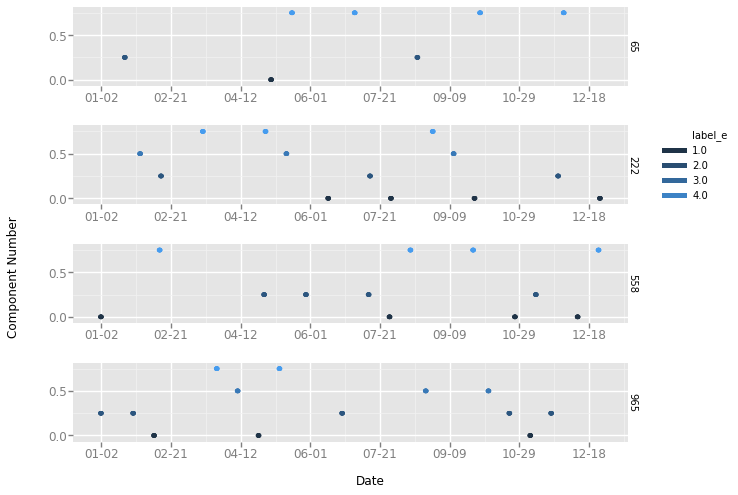

<ggplot: (8757644355634)>

In [20]:
plt_dta = (labeled_features.filter(labeled_features.label_e > 0)
           .where(col("machineID").isin({"65", "558", "222", "965"}))
           .select(labeled_features.machineID, labeled_features.dt_truncated, labeled_features.label_e)
           .toPandas())

# format datetime field which comes in as string
plt_dta['dt_truncated'] = pd.to_datetime(plt_dta['dt_truncated'], format="%Y-%m-%d %H:%M:%S")
plt_dta.label_e = plt_dta.label_e.astype(int)

ggplot(aes(x="dt_truncated", y="label_e", color="label_e"), plt_dta) +\
    geom_point()+\
    xlab("Date") + ylab("Component Number") +\
    scale_x_date(labels=date_format('%m-%d')) +\
    scale_color_brewer(type = 'seq', palette = 'BuGn') +\
    facet_grid('machineID')

Here we see that most of the days are marked as healthy (label = 0 are omitted for plot performance, though the dates are still accurate). Each of the four machines have multiple failures over the course of the dataset. Each labeled failure includes the date of failure and the previous seven days, all are marked with the number indicating the component that failed. 

The goal of the model will be to predict when a failure will occur and which component will fail simultaneously. This will be a multiclass classification problem.

## Write the feature data to cloud storage

Write the final labeled feature data as parquet file an Azure blob storage container. For technical details, see:
https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md


In [21]:
# Create a new container if necessary, otherwise you can use an existing container.
# This command creates the container if it does not already exist. Else it does nothing.
az_blob_service.create_container(STORAGE_CONTAINER_NAME, 
                                 fail_on_exist=False, 
                                 public_access=PublicAccess.Container)

# Write labeled feature data to blob for use in the next notebook
labeled_features.write.mode('overwrite').parquet(FEATURES_LOCAL_DIRECT)

# Delete the old data.
for blob in az_blob_service.list_blobs(STORAGE_CONTAINER_NAME):
    if FEATURES_LOCAL_DIRECT in blob.name:
        az_blob_service.delete_blob(STORAGE_CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(FEATURES_LOCAL_DIRECT + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(STORAGE_CONTAINER_NAME, name, name)

print("Feature engineering final dataset files saved!")

# Time the notebook execution. 
# This will only make sense if you "Run All" cells
toc = time.time()
print("Full run took %.2f minutes" % ((toc - tic)/60))

logger.log("Feature Engineering Run time", ((toc - tic)/60))


/azureml-run/featureengineering_files.parquet/part-00040-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00105-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00162-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00012-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00136-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00085-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00106-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00153-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00142-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featur

/azureml-run/featureengineering_files.parquet/part-00161-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00005-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00007-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00006-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00169-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00166-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00063-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00168-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00176-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featur

/azureml-run/featureengineering_files.parquet/part-00083-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00037-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00148-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00014-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00158-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00025-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00132-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00061-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featureengineering_files.parquet/part-00173-ad7e3049-4e9f-4eab-b732-0cdb220be0ce.snappy.parquet
/azureml-run/featur

# Conclusion

The next step is to build and compare machine learning models using the feature data set we have just created. The `Code\3_model_building.ipynb` notebook works through building a Decision Tree Classifier and a Random Forest Classifier using this data set. 
